In [47]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Input, LSTM
from keras.models import Sequential, load_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import joblib


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [48]:
pm_10_df = pd.read_csv('Data/final_data_for_training/pm10_with_weather.csv', sep=',')

In [49]:
pm_10_df.head(10)

,date,sensor_id,hour,type,value,year,month,day,timestamp,temperature,humidity,wind_speed
0,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,1,pm10,47,2022,1,1,2022-01-01 01:00:00,5.8,78.0,0.8
1,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,2,pm10,69,2022,1,1,2022-01-01 02:00:00,6.0,77.0,2.6
2,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,3,pm10,100,2022,1,1,2022-01-01 03:00:00,6.4,74.0,5.1
3,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,4,pm10,70,2022,1,1,2022-01-01 04:00:00,6.3,74.0,2.1
4,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,5,pm10,59,2022,1,1,2022-01-01 05:00:00,6.0,76.0,2.9
5,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,6,pm10,65,2022,1,1,2022-01-01 06:00:00,5.6,77.0,1.9
6,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,7,pm10,62,2022,1,1,2022-01-01 07:00:00,6.0,74.0,5.2
7,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,8,pm10,64,2022,1,1,2022-01-01 08:00:00,7.9,73.0,2.6
8,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,9,pm10,69,2022,1,1,2022-01-01 09:00:00,11.1,69.0,2.3
9,2022-01-01,01440b05-255d-4764-be87-bdf135f32289,10,pm10,77,2022,1,1,2022-01-01 10:00:00,13.4,64.0,3.3


In [50]:
pm_10_df = pm_10_df.drop(columns=['date', 'timestamp', 'type'])

In [51]:
pm_10_df.head(10)

,sensor_id,hour,value,year,month,day,temperature,humidity,wind_speed
0,01440b05-255d-4764-be87-bdf135f32289,1,47,2022,1,1,5.8,78.0,0.8
1,01440b05-255d-4764-be87-bdf135f32289,2,69,2022,1,1,6.0,77.0,2.6
2,01440b05-255d-4764-be87-bdf135f32289,3,100,2022,1,1,6.4,74.0,5.1
3,01440b05-255d-4764-be87-bdf135f32289,4,70,2022,1,1,6.3,74.0,2.1
4,01440b05-255d-4764-be87-bdf135f32289,5,59,2022,1,1,6.0,76.0,2.9
5,01440b05-255d-4764-be87-bdf135f32289,6,65,2022,1,1,5.6,77.0,1.9
6,01440b05-255d-4764-be87-bdf135f32289,7,62,2022,1,1,6.0,74.0,5.2
7,01440b05-255d-4764-be87-bdf135f32289,8,64,2022,1,1,7.9,73.0,2.6
8,01440b05-255d-4764-be87-bdf135f32289,9,69,2022,1,1,11.1,69.0,2.3
9,01440b05-255d-4764-be87-bdf135f32289,10,77,2022,1,1,13.4,64.0,3.3


In [52]:
pm_10_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158739 entries, 0 to 1158738
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   sensor_id    1158739 non-null  object 
 1   hour         1158739 non-null  int64  
 2   value        1158739 non-null  int64  
 3   year         1158739 non-null  int64  
 4   month        1158739 non-null  int64  
 5   day          1158739 non-null  int64  
 6   temperature  1158739 non-null  float64
 7   humidity     1158739 non-null  float64
 8   wind_speed   1158739 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 79.6+ MB


In [53]:
pm_10_df.describe()

,hour,value,year,month,day,temperature,humidity,wind_speed
count,1.158739e+06,1.158739e+06,1.158739e+06,1.158739e+06,1.158739e+06,1.158739e+06,1.158739e+06,1.158739e+06
mean,1.202042e+01,2.461216e+01,2.023312e+03,6.338160e+00,1.572654e+01,1.552041e+01,6.327198e+01,5.320384e+00
std,6.644194e+00,4.472560e+01,7.288441e-01,3.307369e+00,8.770061e+00,9.523831e+00,1.952541e+01,2.767698e+00
min,1.000000e+00,0.000000e+00,2.022000e+03,1.000000e+00,1.000000e+00,-9.200000e+00,1.100000e+01,0.000000e+00
25%,6.000000e+00,7.000000e+00,2.023000e+03,3.000000e+00,8.000000e+00,7.900000e+00,4.900000e+01,3.500000e+00
50%,1.200000e+01,1.200000e+01,2.023000e+03,6.000000e+00,1.600000e+01,1.530000e+01,6.500000e+01,5.000000e+00
75%,1.800000e+01,2.600000e+01,2.024000e+03,9.000000e+00,2.300000e+01,2.270000e+01,7.900000e+01,6.600000e+00
max,2.300000e+01,1.995000e+03,2.024000e+03,1.200000e+01,3.100000e+01,3.930000e+01,1.000000e+02,2.930000e+01


In [54]:
# idx_to_remove = pm_10_df['value'].idxmax()

# # Drop the row
# pm_10_df = pm_10_df.drop(index=idx_to_remove)

In [55]:
target_col = 'value'

In [56]:
# pm_10_df[target_col] = np.log(pm_10_df[target_col])


<Axes: ylabel='Frequency'>

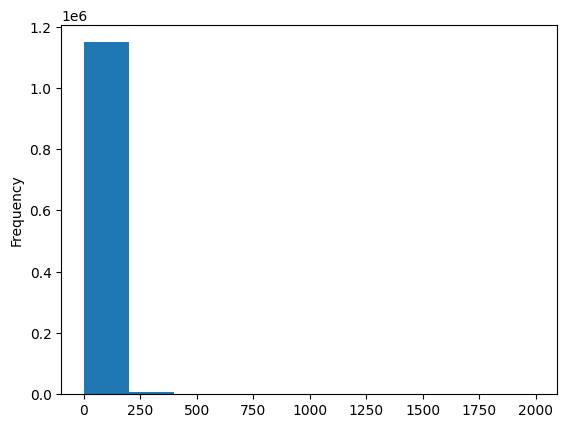

In [57]:
pm_10_df[target_col].plot.hist()

In [58]:
pm_10_df[target_col].min()

0

In [59]:
Y_scaler = MinMaxScaler()

pm_10_df[target_col] = Y_scaler.fit_transform(pm_10_df[[target_col]])

In [60]:
joblib.dump(Y_scaler, 'y_scaler.pkl')

['y_scaler.pkl']

In [61]:
X = pm_10_df.drop(columns=[target_col])
Y = pm_10_df[target_col]

In [62]:
X.columns

Index(['sensor_id', 'hour', 'year', 'month', 'day', 'temperature', 'humidity',
       'wind_speed'],
      dtype='object')

In [63]:
Y

0          0.023559
1          0.034586
2          0.050125
3          0.035088
4          0.029574
             ...   
1158734    0.133333
1158735    0.064662
1158736    0.062657
1158737    0.090226
1158738    0.089223
Name: value, Length: 1158739, dtype: float64

In [64]:
type(Y)

pandas.core.series.Series

In [65]:
# Y = Y.sort_values().iloc[:-3]

In [66]:
# bins = np.linspace(min(Y), max(Y), 4)
# y_binned = np.digitize(Y, bins)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=SEED, test_size=0.3, stratify=y_binned)

In [67]:
X = X.drop(columns=['sensor_id'])

In [68]:
X.columns

Index(['hour', 'year', 'month', 'day', 'temperature', 'humidity',
       'wind_speed'],
      dtype='object')

In [69]:
Y_binned = pd.qcut(Y, q=4, labels=False)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, shuffle=True, random_state=SEED, test_size=0.3, stratify=Y_binned
)

In [70]:
# y_binned_df = pd.DataFrame(data=y_binned)

In [71]:
# y_binned_df[0].value_counts()

In [72]:
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]

In [73]:
X_scaler = MinMaxScaler()

In [74]:
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

In [75]:
joblib.dump(X_scaler, 'x_scaler.pkl')

['x_scaler.pkl']

In [27]:
# model = Sequential()
# model.add(Input(shape=(X.shape[1],)))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1))
# model.summary()

In [28]:
X_train.shape

(811117, 7)

In [29]:
X_test.shape

(347622, 7)

In [30]:
# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

In [31]:
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (347622, 1, 7)

In [32]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True)) 
# model.add(Dropout(0.2))
# model.add(LSTM(32))  
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.summary()

In [33]:
# model.compile(tf.optimizers.Adam(0.001), loss='mae', metrics=['mae'])

In [34]:
# es_cbk = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=2)
# chp_cbk = ModelCheckpoint(filepath='pm_10_model.keras', save_best_only=True,)

# m_history = model.fit(X_train, Y_train,
#                       epochs=100,
#                       callbacks=[es_cbk, chp_cbk],
#                       validation_data=(X_test, Y_test)
# )

In [35]:
# model = load_model('pm_10_model.keras')

In [36]:
# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=-1)


In [37]:
# print("MAE ->", mean_absolute_error(Y_test, y_pred))
# print("RMSE ->", mean_squared_error(Y_test, y_pred)**0.5)
# print("R2 ->", r2_score(Y_test, y_pred))

In [38]:
# print("MAE ->", mean_absolute_error(Y_test, y_pred))
# print("RMSE ->", mean_squared_error(Y_test, y_pred)**0.5)
# print("R2 ->", r2_score(Y_test, y_pred))

In [40]:
import xgboost as xgb

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.1),  # Uniform distribution between 0.01 and 0.1
    'max_depth': [3, 6, 10],
    'subsample': uniform(0.8, 0.2),  # Uniform distribution between 0.8 and 1.0
    'colsample_bytree': uniform(0.8, 0.2)  # Uniform distribution between 0.8 and 1.0
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(random_state=42), 
    param_distributions=param_dist, 
    n_iter=100,  
    cv=3, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    random_state=42
)

# Fit the model
random_search.fit(X_train, Y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {random_search.best_params_}")

# Best model
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate best model
mae_best = mean_absolute_error(Y_test, y_pred_best)
rmse_best = root_mean_squared_error(Y_test, y_pred_best)
r2_best = r2_score(Y_test, y_pred_best)

print(f"Best Model MAE: {mae_best}")
print(f"Best Model RMSE: {rmse_best}")
print(f"Best Model R²: {r2_best}")


Best Hyperparameters: {'colsample_bytree': 0.8046124850082832, 'learning_rate': 0.06247746602583892, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8093331326427231}
Best Model MAE: 0.006175113403855879
Best Model RMSE: 0.01749138864595834
Best Model R²: 0.3861652092382635


In [42]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [43]:
rfr_pred = rf_model.predict(X_test)

In [44]:
print("MAE ->", mean_absolute_error(Y_test, rfr_pred))
print("RMSE ->", root_mean_squared_error(Y_test, rfr_pred)**0.5)
print("R2 ->", r2_score(Y_test, rfr_pred))

MAE -> 0.006047459323183903
RMSE -> 0.1330407295242246
R2 -> 0.3714477417642572


In [45]:
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [46]:
joblib.dump(best_model, 'xgboost_model.pkl')

['xgboost_model.pkl']